## Advanced use of federated processing

Federations of openEO backends allow to interact with multiple backends in a transparant manner. It can however help to understand a bit more about the federated nature of the backend to effectively work with a federation. 


### Visual hints in openEO editor

For starters, you may want to know the current members of the federation. The web editor shows this as part of the server info:

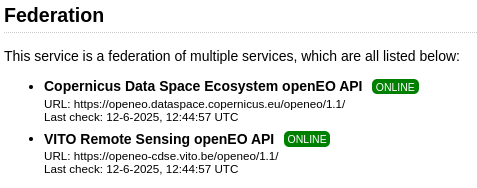

and you can get the same information when working in Python or Jupyter notebooks by requesting capabilities:

In [4]:
import openeo
openeo.connect('openeofed.dataspace.copernicus.eu').capabilities()

For processes, you can similarly find out which backends support a given process. This is important, because it determines whether your process graph will work on more than one backend:


In [8]:
connection = openeo.connect('openeofed.dataspace.copernicus.eu')

In [6]:
connection.describe_process("add")

{'categories': ['math'],
 'deprecated': False,
 'description': 'Sums up the two numbers `x` and `y` (*`x + y`*) and returns the computed sum.\n\nNo-data values are taken into account so that `null` is returned if any element is such a value.\n\nThe computations follow [IEEE Standard 754](https://ieeexplore.ieee.org/document/8766229) whenever the processing environment supports it.',
 'examples': [{'arguments': {'x': 5, 'y': 2.5}, 'returns': 7.5},
  {'arguments': {'x': -2, 'y': -4}, 'returns': -6},
  {'arguments': {'x': 1, 'y': None}, 'returns': None}],
 'experimental': False,
 'federation:backends': ['cdse', 'terrascope'],
 'id': 'add',
 'links': [{'href': 'http://mathworld.wolfram.com/Sum.html',
   'rel': 'about',
   'title': 'Sum explained by Wolfram MathWorld'},
  {'href': 'https://ieeexplore.ieee.org/document/8766229',
   'rel': 'about',
   'title': 'IEEE Standard 754-2019 for Floating-Point Arithmetic'}],
 'parameters': [{'description': 'The first summand.',
   'name': 'x',
   'schema': {'type': ['number', 'null']}},
  {'description': 'The second summand.',
   'name': 'y',
   'schema': {'type': ['number', 'null']}}],
 'returns': {'description': 'The computed sum of the two numbers.',
  'schema': {'type': ['number', 'null']}},
 'summary': 'Addition of two numbers'}

For collections, the federation uses the 'summaries' to indicate which backends host a certain collection:

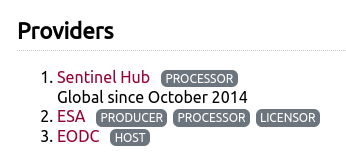

In [9]:
for collection_id in connection.list_collection_ids():
    collection_metadata = connection.describe_collection(collection_id)
    federation_backends = collection_metadata["summaries"]["federation:backends"]
    print(f"Provided by {repr(federation_backends):16s}: {collection_id} ")

Provided by ['cdse']        : SENTINEL3_OLCI_L1B 
Provided by ['cdse']        : SENTINEL3_SLSTR 
Provided by ['cdse']        : SENTINEL_5P_L2 
Provided by ['cdse']        : COPERNICUS_VEGETATION_PHENOLOGY_PRODUCTIVITY_10M_SEASON1 
Provided by ['cdse']        : COPERNICUS_VEGETATION_PHENOLOGY_PRODUCTIVITY_10M_SEASON2 
Provided by ['cdse']        : ESA_WORLDCOVER_10M_2021_V2 
Provided by ['cdse']        : COPERNICUS_VEGETATION_INDICES 
Provided by ['cdse']        : SENTINEL2_L1C 
Provided by ['cdse']        : SENTINEL2_L2A 
Provided by ['cdse']        : SENTINEL1_GRD 
Provided by ['cdse']        : COPERNICUS_30 
Provided by ['cdse']        : LANDSAT8_L2 
Provided by ['cdse']        : SENTINEL3_SYN_L2_SYN 
Provided by ['cdse']        : SENTINEL3_SLSTR_L2_LST 
Provided by ['cdse']        : SENTINEL1_GLOBAL_MOSAICS 
Provided by ['cdse']        : SENTINEL3_OLCI_L2_LAND 
Provided by ['cdse']        : SENTINEL3_OLCI_L2_WATER 
Provided by ['cdse']        : SENTINEL3_SYN_L2_AOD 
Provided by ['te

In [10]:
temporal_extent = "2024-08"
spatial_extent = {"west": 5.07, "south": 51.21, "east": 5.10, "north": 51.23}

### Indicating use of a specific backend

As collections can be offered on multiple backends, your batch job can end up on multiple backends based on a logic that is internal to the specific federation configuration.

This can have a few drawbacks:

* Job results might differ slightly between backends
* Cost and performance might differ

To avoid this, you can be explicit about which backend to use for a given 'load_collection' call, by using the property filtering mechanism:


In [27]:
connection = connection.authenticate_oidc()

Authenticated using refresh token.


In [ ]:
from openeo import collection_property

terrascope_job = (
    connection.load_collection(
        "ESA_WORLDCEREAL_ACTIVECROPLAND",                
        properties=[collection_property("federation:backends")=="terrascope"]
    )
    .filter_temporal(extent=temporal_extent)
    .filter_bbox(spatial_extent)
).create_job()


In [31]:
terrascope_job

<BatchJob job_id='terrascope-j-2506121329204653864fdf31271ab3dd'>

### Federated processing

Federated processing happens when a single job requires work on multiple backends. 
The most common trigger for federated processing is when datasets are not available on the same backend.

To keep the demo simple but not too trivial, we're going to build the following process graph:

```
    (at CDSE)            (at Terrascope)
  SENTINEL2_L2A       TERRASCOPE_S2_NDVI_V2
        |                      |
  filter_temporal        filter_temporal
        |                      |
  filter_spatial         filter_spatial
        |                      |
  reduce_dimension      reduce_dimension
   (temporal mean)      (temporal mean)
              \           /
               merge_cubes
                    |
                save_result
```


- two `load_collection` nodes, each one targetting a different backend
- basic processing on each collection: spatio-temporal filtering and doing the temporal mean
- merge that together in a single cube

Authenticated using refresh token.


Load and process the `SENTINEL2_L2A` data (targeting the CDSE backend):

In [17]:
cube1 = (
    connection.load_collection(
        "SENTINEL2_L2A",
        bands=["B02"],
        max_cloud_cover=50,
    )
    .filter_temporal(extent=temporal_extent)
    .filter_bbox(spatial_extent)
)
cube1 = cube1.reduce_temporal("mean")

Load and process the `TERRASCOPE_S2_NDVI_V2` data (targeting Terrascope):

In [18]:
cube2 = (
    connection.load_collection(
        "TERRASCOPE_S2_NDVI_V2",
        bands=["NDVI_10M"]
    )
    .filter_temporal(extent=temporal_extent)
    .filter_bbox(spatial_extent)
)
cube2 = cube2.reduce_temporal("mean")

Merge both cubes:

In [19]:
merged = cube1.merge_cubes(cube2)

We want the final result in netCDF format:

In [20]:
saved = merged.save_result(format="netCDF")

In [21]:
job = saved.create_job(
    title="Deep graph splitting demo",
    job_options={
        "split_strategy": {
            "crossbackend": {
                "method": "deep",
                # "primary_backend": "vito",
            },
        },
    },
    validate=False,
)
job.job_id

'agg-pj-20250612-131446'

In [22]:
job.start()

<BatchJob job_id='agg-pj-20250612-131446'>

As this batch job is federated, it requires doing work on 2 different backends. This involves creating partial jobs, which will also be visible in your job listing:

In [26]:
connection.list_jobs(limit=3)

[{'created': '2025-06-12T13:14:48Z',
  'id': 'cdse-j-2506121314484dd2a68e75c9600b0f77',
  'status': 'running',
  'title': 'Crossbackend job pj-20250612-131446:cdse:reducedimension1',
  'updated': '2025-06-12T13:17:16Z'},
 {'created': '2025-06-11T11:25:05Z',
  'id': 'cdse-j-25061111250543a88b9ced4ef91ff5b9',
  'progress': 100,
  'status': 'finished',
  'title': 'ClouDInSAR_coherence_from_preprocessing',
  'updated': '2025-06-11T11:27:14Z'},
 {'created': '2025-06-11T11:16:16Z',
  'id': 'cdse-j-2506111116164040b35639935bfe410f',
  'progress': 100,
  'status': 'finished',
  'updated': '2025-06-11T11:19:13Z'},
 {'created': '2025-06-12T13:14:49Z',
  'id': 'terrascope-j-250612131449444d8fa051231a5343cc',
  'progress': 0,
  'status': 'queued',
  'title': 'Crossbackend job pj-20250612-131446:main',
  'updated': '2025-06-12T13:15:45Z'},
 {'created': '2025-03-18T11:51:02Z',
  'id': 'terrascope-j-250318115102498fb456e0c4fe27d989',
  'progress': 100,
  'status': 'finished',
  'title': 'dmp',
  'updated': '2025-03-18T11:53:27Z'},
 {'created': '2025-03-18T10:55:26Z',
  'id': 'terrascope-j-25031810552648c0947d42436abf7773',
  'status': 'error',
  'title': 'cgls',
  'updated': '2025-03-18T10:57:26Z'},
 {'created': '2025-06-12T13:14:46Z',
  'id': 'agg-pj-20250612-131446',
  'progress': 0,
  'status': 'running',
  'title': 'Deep graph splitting demo'}]

In [32]:
job

<BatchJob job_id='agg-pj-20250612-131446'>